In [2]:
from langgraph.graph import StateGraph, END
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
import os
from typing import Optional
from dotenv import load_dotenv
from IPython.display import  Image, display

In [3]:
load_dotenv()
openai_api_key=os.getenv('OPENAI_API_KEY')

In [15]:
# Modelo LLM (pode usar gpt-4o, gpt-3.5, etc)
llm = ChatOpenAI(model="gpt-4.1-mini-2025-04-14", openai_api_key=openai_api_key)

class State(dict):
    mensagem: str
    sentimento: str
    resultado: str
# Estado compartilhado entre os nós
def criar_estado_inicial(mensagem_usuario):
    return {"mensagem": mensagem_usuario, "sentimento": None, "resultado": None}

# Nó 1: Analisar o sentimento
def analisar_sentimento(state):
    prompt = ChatPromptTemplate.from_template(
        "Classifique o sentimento da seguinte mensagem como 'positivo' ou 'negativo': {mensagem}. Use apenas uma palavra."
    )
    resposta = llm.invoke(prompt.format_messages(mensagem=state["mensagem"]))
    state["sentimento"] = resposta.content.lower()
    return state

# Nó 2: Tratar mensagem positiva
def tratar_positivo(state):
    state["resultado"] = "Resposta positiva detectada. Agradecendo ao usuário."
    return state

# Nó 3: Tratar mensagem negativa
def tratar_negativo(state):
    state["resultado"] = "Resposta negativa detectada. Escalando para atendimento humano."
    return state

# Lógica condicional: para onde ir após a análise
def escolher_proximo(state):
    if "positivo" in state["sentimento"]:
        return "tratar_positivo"
    else:
        return "tratar_negativo"


In [16]:
# Construção do grafo
graph = StateGraph(State)
graph.add_node("analisar_sentimento", analisar_sentimento)
graph.add_node("tratar_positivo", tratar_positivo)
graph.add_node("tratar_negativo", tratar_negativo)
graph.set_entry_point("analisar_sentimento")
graph.add_conditional_edges("analisar_sentimento", escolher_proximo)
graph.add_edge("tratar_positivo", END)
graph.add_edge("tratar_negativo", END)

# Compilar e executar
app = graph.compile()

In [17]:
# Exemplo de uso:
estado_inicial = criar_estado_inicial("Estou muito satisfeito com o atendimento!")
app.invoke(estado_inicial)

{'mensagem': 'Estou muito satisfeito com o atendimento!',
 'sentimento': 'positivo',
 'resultado': 'Resposta positiva detectada. Agradecendo ao usuário.'}

In [18]:
# Exemplo de uso:
estado_inicial = criar_estado_inicial("Que ruim")
app.invoke(estado_inicial)

{'mensagem': 'Que ruim',
 'sentimento': 'negativo',
 'resultado': 'Resposta negativa detectada. Escalando para atendimento humano.'}

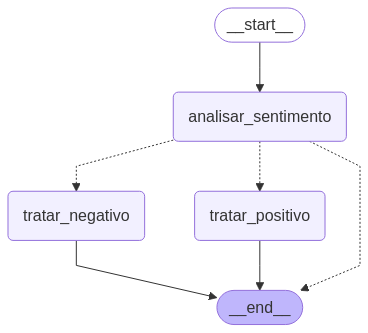

In [19]:
display(Image(app.get_graph().draw_mermaid_png()))